# Instructions

For this assignment you will use PyTorch instead of EDF to implement and train neural networks. You should install it (there are multiple tutorials online and it is especially easy if you're using Anaconda). You also have to install the seaborn library which offers some plotting functions that we'll use. Check https://pytorch.org/tutorials/ for some PyTorch tutorials -- this assignment assumes that you know the basics like defining models with multiple modules and coding up functions to do training with PyTorch optimizers.

If you have a nvidia GPU it is a good idea to install CUDA and PyTorch with gpu support so you can run everything on gpu. Another option is to run everything on Google Colab, which offers some free gpu time (check https://colab.research.google.com/ and look for tutorials online).

Unlike previous assignments, in this one you will have to do some writing instead of just coding. Try to keep your answers short and precise, and you are encouraged to write equations if needed (you can do that using markdown cells). You can also use code as part of your answers (like plotting and printing, etc). Blue text indicates questions or things that you should discuss/comment, and there will red "ANSWER (BEGIN)" and "ANSWER (END)" markdown cells to indicate that you should add cells with your writeup between these two. **Make sure not to redefine variables or functions in your writeup, which can change the behavior of the next cells.**

Finally, you might have to do minor changes to the provided code due to differences in python/pytorch versions. You can post on piazza if there's a major, non-trivial change that you had to do (so other students can be aware of it and how to proceed), but for minor changes you should just apply them and keep working on the assignment.

In [1]:
import torch, math, copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Learning rate as temperature in SGD

In this first part you will study how the learning rate acts as temperature in the stationary distribution of the stochastic differential equation (SDE) that approximates SGD. First, recall the SDE derived in the lectures that approximates the continuous-time behavior of SGD:

$$dw = - \nabla L(w) dt + \epsilon \sqrt{\eta dt}, \quad \epsilon \sim \mathcal N(0, \sigma^2), \eta \propto dt$$

where $\eta$ is the learning rate and $\sigma$ captures the noise level of stochastic gradients (i.e. gradients computed from a mini-batch).

Our goal is to sample from the stationary distribution of the above SDE. To do that, we will use Stochastic Gradient Langevin Dynamics (SGLD), an algorithm commonly used to sample from the parameter's posterior -- this is unlike SGD, whose goal is to simply minimize the objective $L$, which can be seen as finding the modes of the parameter's posterior (this will become more clear as you run the experiments and observe the results).

SGLD works by adding an additional source of noise such that the produced iterates are samples of the posterior instead of modes. Unlike the noise in the SDE above (which captures the variance of stochastic gradients), the additional term we will add scales as $\sqrt{\eta}$, meaning that it will dominate the updates if the learning rate $\eta$ is small.

The SGLD update rule for the above SDE is:

$$w_{t+1} = w_t -  \eta \nabla L(w) + \eta \epsilon_1 + \sqrt{\eta} \epsilon_2, \quad \epsilon_1 \sim \mathcal N(0, \sigma^2), \epsilon_2 \sim \mathcal N(0, 1)$$

The update above can be also understood as follows. Let us consider an iterate $w$ and start by taking the SGD update

$$w^{SGD} = w - \eta \nabla \tilde L(w)$$

where $\nabla \tilde L(w)$ is a stochastic estimate of the true gradient $\nabla L(w)$, which we approximate as $\nabla \tilde L(w) \approx \nabla L(w) + \epsilon_1$, where $\epsilon_1$ is normally-distributed with variance $\sigma^2$ that decreases with the mini-batch size (check the lecture slides for more details on this step). This yields the following update:

$$w^{LD} = w - \eta \nabla L(w) + \eta \epsilon_1, \quad \epsilon_1 \sim \mathcal N(0, \sigma^2)$$

Finally, since we want to perform inference and not minimize $L$, we sample $w^{SGLD} \sim \mathcal N(w^{LD}, \eta)$, or equivalently:

$$w^{SGLD} = w - \eta \nabla L(w) + \eta \epsilon_1 + \sqrt{\eta} \epsilon_2, \quad \epsilon_1 \sim \mathcal N(0, \sigma^2), \epsilon_2 \sim \mathcal N(0, 1)$$

You can check Welling & Teh, Bayesian Learning via Stochastic Gradient Langevin Dynamics for more details on SGLD, although this is not needed to complete the assignment: https://www.ics.uci.edu/~welling/publications/papers/stoclangevin_v6.pdf. Another reference is Stochastic Gradient Descent as Approximate Bayesian Inference by Mandt et al.: https://arxiv.org/abs/1704.04289.

The cell below define a 1-dimensional problem characterized by a loss $L(w)$, along with some functions that you'll use for plotting.

In [2]:
low, high = -60, 60

def L(w):
    return 10*torch.clamp((1 + torch.cos(w) + 0.2*torch.abs(w - 5*math.pi)) / 5.0, max=1.75)

def plot_iters(w_space, loss_space, w_iters=None, loss_iters=None, focus=False):
    plt.xlabel("w")
    plt.ylabel("loss")
    plt.plot(w_space, loss_space)
    if not (w_iters is None or loss_iters is None):
        plt.plot(w_iters, loss_iters, marker='x')
        if focus:
            min_w, max_w = min(w_iters), max(w_iters)
            min_l, max_l = min(loss_iters), max(loss_iters)
            gap_w, gap_l = max_w - min_w, max_l - min_l
            plt.xlim(min_w - gap_w/4, max_w + gap_w/4)
            plt.ylim(min_l - gap_l/4, max_l + gap_l/4)
    plt.tight_layout()
    plt.show()
    plt.clf()
    
def plot_loss(loss_iters):
    plt.xlabel("iter")
    plt.ylabel("loss")
    plt.plot(np.arange(len(loss_iters)), loss_iters)
    plt.tight_layout()
    plt.show()
    plt.clf()
    
def plot_density(w_space, loss_space, w_iters):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('w')
    ax1.set_ylabel('loss')
    ax1.plot(w_space, loss_space)
    ax2 = ax1.twinx()
    ax2.set_ylabel('p(w)')
    sns.distplot(w_iters, hist = False, kde = True, color='orange',
                 kde_kws = {'shade': True, 'bw' : 0.1, 'clip' : (low, high)})
    fig.tight_layout()
    plt.show()
    plt.clf()

The cell below plots the loss, which was designed to capture some characteristics of deep learning: it contains multiple local minima, is highly non-convex and its gradients provide little to no signal if the parameters become too large.

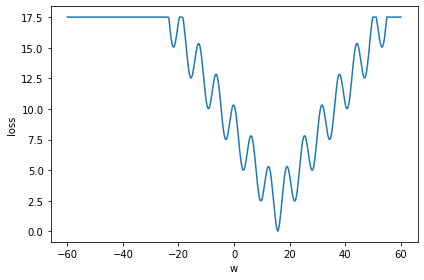

<Figure size 432x288 with 0 Axes>

In [3]:
w_space = torch.linspace(low, high, 500)
loss_space = L(w_space)
w_space, loss_space = w_space.numpy(), loss_space.numpy()
plot_iters(w_space, loss_space)

An example of how you should aim to answer questions / add discussions is:

**<span style="color:blue">
    Does the above function admit multiple global minima?
</span>**

**<span style="color:red">
    --- ANSWER (BEGIN) ---
</span>**

No, check the plot produced by the cell below: it has a single global minimum at $w^* \approx 16$ with $L(w^*) \approx 0$, and from the plot above we can see that all other local minima have $L(w) \geq 2$.

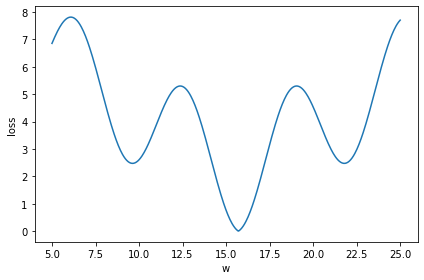

<Figure size 432x288 with 0 Axes>

In [4]:
w_space2 = torch.linspace(5, 25, 500)
plot_iters(w_space2.numpy(), L(w_space2).numpy())

**<span style="color:red">
    --- ANSWER (END) ---
</span>**

Finish implementing SGLD in the cell below. For this experiment you can set $\sigma = 0.1$ as the standard deviation of $\epsilon_1$. Your implementation should work regardless of the dimension of w: you should treat each component as an independent iterate and perform SGLD in parallel for all components of w, i.e. $w_{t+1}[i] = w_t[i] -  \eta \nabla L(w[i]) + \eta \epsilon_1[i] + \sqrt{\eta} \epsilon_2[i]$.

The returned variables w_iters and loss_iters should have shape (T x N), where T is the number of SGLD iterations and N is the number of initial w iterates (the dimension of w), with $w_{iters}[t,i] = w_t[i]$ and $loss_{iters}[t,i] = L(w_t[i])$.

In [5]:
def SGLD(iters, w, lr):
    w_iters = []
    loss_iters = []
    
    # possibly insert code here (depends on how you implement the function)
    sigma = 0.1

    for i in range(iters):
        loss = L(w)
        w_iters.append(w.clone().data.numpy())
        loss_iters.append(loss.data.numpy())
        # insert code here to perform a SGLD update step
        w_dims = list(w.data.size())
        if w_dims == []:
          w_size = 1
          loss.backward()
          epsilon_1 = torch.from_numpy(np.random.normal(0,sigma,w_size))[0]
          epsilon_2 = torch.from_numpy(np.random.normal(0,1,w_size))[0]
        else:
          w_size = w_dims[0]
          loss.backward(torch.ones(w_size))
          epsilon_1 = torch.from_numpy(np.random.normal(0,sigma,w_size))
          epsilon_2 = torch.from_numpy(np.random.normal(0,1,w_size))
        
        with torch.no_grad():
          w -= lr * w.grad - lr * epsilon_1 - (lr**(1/2)) * epsilon_2 
        w.grad.data.zero_()
        
    return np.asarray(w_iters), np.asarray(loss_iters)

Let's check how the iterates look like with learning rates of vastly different magnitudes (also use this as a sanity-check of your implementation), starting from w=30.

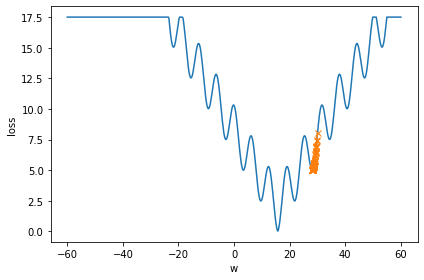

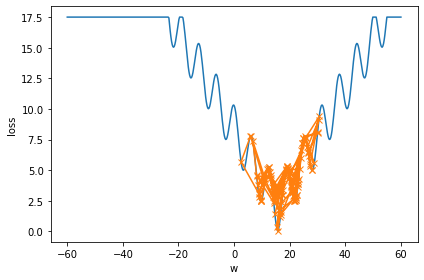

<Figure size 432x288 with 0 Axes>

In [6]:
for lr in [0.02, 2.0]:
    w = nn.Parameter(torch.tensor(30.))
    w_iters, loss_iters = SGLD(100, w, lr)
    plot_iters(w_space, loss_space, w_iters, loss_iters)

Now, initialize 10k different values for w from an uniform distribution over $[0,40]$. In the cell below w should be a 10k-dimensional vector and the SGLD call will likely only work if your implementation works for batched w iterates. Also remember that the components should be updated independently, so you should not take the average loss when computing gradients.

After 1500 iterations we will plot the distribution of the last SGLD iterates (one for each of the 10k randomly-initialized values), along with the expected loss per iteration. The first plot shows the loss function (blue, left y-axis) and the distribution of the 10k sampled parameters (orange, with values given by the x-axis and probability in the right y-axis).

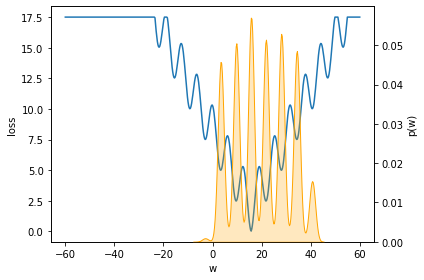

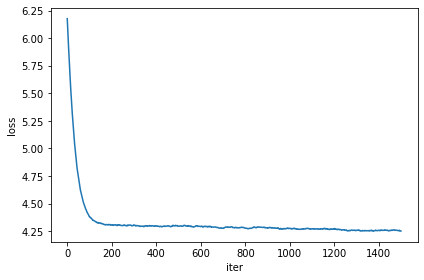

Expected loss: 4.251374632985415


<Figure size 432x288 with 0 Axes>

In [7]:
lr = 0.02
w = nn.Parameter(torch.from_numpy(np.random.uniform(0,40,10000))) 
w_iters, loss_iters = SGLD(1500, w, lr)
plot_density(w_space, loss_space, w_iters[-1])
plot_loss(loss_iters.mean(1))
print("Expected loss: {}".format(loss_iters[-1].mean()))

**<span style="color:blue">
    Check the first of the two plots above. What can you say about the estimated distribution $p(w)$ and the corresponding loss value $L(w)$? Does $p(w)$ look like a Gibbs distribution with energy $E = L$, i.e. $p(w) \propto \exp \left( \frac{-L(w)}{T} \right)$ for some temperature $T$?
</span>**

**<span style="color:red">
    --- ANSWER (BEGIN) ---
</span>**

The estimated distribution of $p(\omega)$ has spikes around the multiple local minimum of the loss function, indicating that SGD is often stuck at local minimum. $p(\omega)$ indeed looks like a Gibbs distribution for some temperature $T$, because we see that the distribution assigns the same probability (or weight) to parameter settings with similar loss value. 

**<span style="color:red">
    --- ANSWER (END) ---
</span>**

Repeat the above but with a learning rate of 1.5.

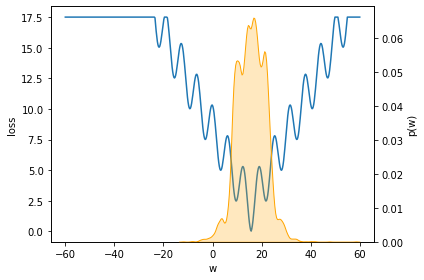

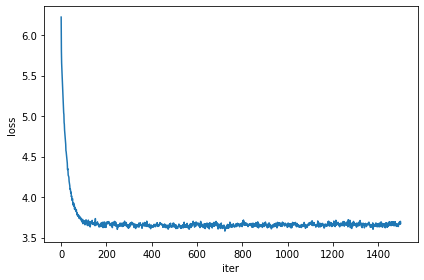

Expected loss: 3.6738218871199546


<Figure size 432x288 with 0 Axes>

In [8]:
lr = 1.5
w = nn.Parameter(torch.from_numpy(np.random.uniform(0,40,10000)))
w_iters, loss_iters = SGLD(1500, w, lr)
plot_density(w_space, loss_space, w_iters[-1])
plot_loss(loss_iters.mean(1))
print("Expected loss: {}".format(loss_iters[-1].mean()))

**<span style="color:blue">
    Compare the two parameter distributions (produced with large/small learning rates) and discuss how and why they differ. What can you say about their temperatures?
</span>**

**<span style="color:red">
    --- ANSWER (BEGIN) ---
</span>**

The stationary distribution is more concentrated around the actual global minima compared to the case when learning rate is small. The temperature is lower, as the expected loss is lower (3.66 vs 4.24). This is because for this loss function, there are many local minimum. A very small learning rate means that SGD doesn't move much through the parameter space and is easily stuck in a local min. Setting to a higher learning rate actually increases the chance that SGD can jump to parameter values around the global min and stay around there.  


**<span style="color:red">
    --- ANSWER (END) ---
</span>**

Now, let's check what happens if we decay the learning rate of SGLD by a factor of 2 every 500 iterations.

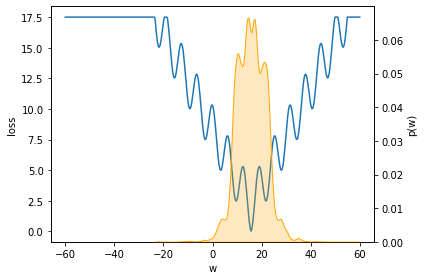

<Figure size 432x288 with 0 Axes>

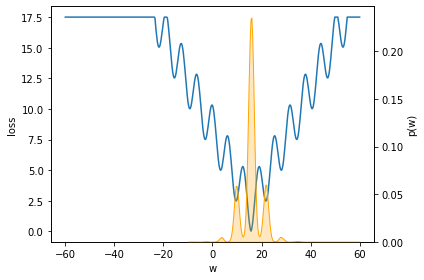

<Figure size 432x288 with 0 Axes>

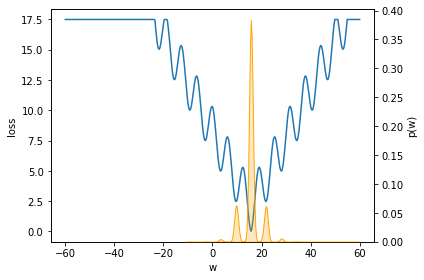

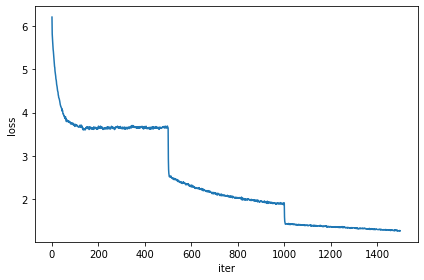

Expected loss: 1.2681278956679745


<Figure size 432x288 with 0 Axes>

In [9]:
lr = 1.5
# insert code here, same initialization previously
w = nn.Parameter(torch.from_numpy(np.random.uniform(0,40,10000)))
total_loss_iters = []
for k in range(3):
    w_iters, loss_iters = SGLD(500, w, lr)
    plot_density(w_space, loss_space, w_iters[-1])
    lr = lr/2.0
    total_loss_iters.append(loss_iters)
    
total_loss_iters = np.concatenate(total_loss_iters)
plot_loss(total_loss_iters.mean(1))
print("Expected loss: {}".format(total_loss_iters[-1].mean()))

**<span style="color:blue">
    Compare the final expected loss achieved in the three experiments above. Give an explanation for how the parameter density and the loss curve evolved as the learning rate was decayed. Have you seen a curve with a similar shape in the course lectures?
</span>**

**<span style="color:red">
    --- ANSWER (BEGIN) ---
</span>**

The final expected loss achieved is much lower at 1.29 compared to previous experiments with fixed learning rates high or low. We can see that as learning rate was decayed, the parameter density became more and more concentrated around the value that achieves the global min. As density became more and more concentrated around the global min, expected loss also declines, which is shown by the step-like kinks in the loss plot. This happens because we allow the learning rate to be large initially so that SGD is given the chance to explore the parameter space without getting stuck at local minimum, and as the learning rate decays, it prevents SGD from leaving the area around global min and allows it to get closer and closer to the global min. This curve is also seen in the plots from the original ResNet paper from lecture. In those plots, both training and validation error drops around the iterations at which the learning rate is reduced by a factor of 2. 

**<span style="color:red">
    --- ANSWER (END) ---
</span>**

Finally, we will check whether the discrete decays adopted above can be replaced by a more gradual, smooth schedule.

In the cell below implement a schedule $\eta_t = \frac{\eta}{\sqrt t}$ and run SGLD for 1500 iterations, again starting from 10k randomly-initialized parameters.

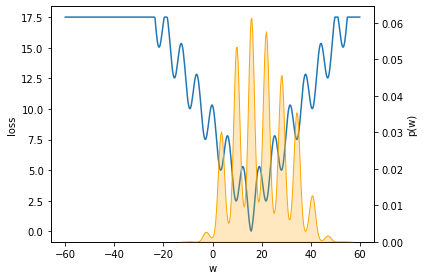

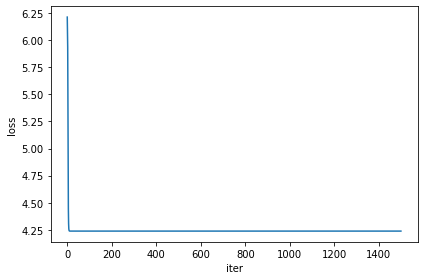

Expected loss: 4.239429664631858


<Figure size 432x288 with 0 Axes>

In [27]:
cur_lr = 2 # insert a reasonably large value 

w = nn.Parameter(torch.from_numpy(np.random.uniform(0,40,10000))) # insert code here, same initialization previously
total_loss_iters = []
for k in range(1500):
    if(k>0):
      cur_lr = cur_lr / (k ** (1/2))
    w_iters, loss_iters = SGLD(1, w, cur_lr)
    total_loss_iters.append(loss_iters)
plot_density(w_space, loss_space, w_iters[-1])

total_loss_iters = np.concatenate(total_loss_iters)
plot_loss(total_loss_iters.mean(1))
print("Expected loss: {}".format(total_loss_iters[-1].mean()))

**<span style="color:blue">
    Try different values for $\eta$ and try to match or outperform the discrete schedule. Were you able to match it? If no, why not?
</span>**

**<span style="color:red">
    --- ANSWER (BEGIN) ---
</span>**

No, I was not able to match or outperform the discrete schedule. This is because for this particular continuous schedule, the rate of decay is too fast. If I set the learning rate to be reasonably big (around 1.5~5), then it quickly decays to something very small before SGD can find the global minimum. It does not matter if I set the learning rate to be unreasonably huge (10 or 20), because what it matters is whether SGD is given the chance to find the global minima at a reasonable learning rate. Learning rate of 10 is obviously not reasonable as SGD will simply jump all over the parameter space. When the learning rate schedule is decayed to a reasonable value, it will simply continue to decay at a fast rate towards extremely slow values without giving the algorithm chance to explore the parameter space at the appropriate learning rate. Therefore, SGD is still likely to be just stuck at a local minima. 

In this case, since the loss function has so many local minimum, discrete schedule is more appropriate as it gives SGD the chance to explore the parameter space at reasonable rate before slowing down to fine-tune itself towards the global min. 

**<span style="color:red">
    --- ANSWER (END) ---
</span>**

# The role of the learning rate in deep learning

In this second part you'll check whether the behavior observed above is also observable when training neural networks. In particular, you'll study how the magnitude of the learning rate affects a model's performance, especially when annealed properly.

The following experiments will use a small subset of MNIST. We will use 256 samples for training and 2048 for test.

In [35]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST("data", train=True, download=True, transform=transform)
sampler=torch.utils.data.sampler.SubsetRandomSampler(range(256))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, sampler=sampler)

test_dataset = datasets.MNIST("data", train=False, download=True, transform=transform)
sampler=torch.utils.data.sampler.SubsetRandomSampler(range(2048))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, sampler=sampler)

Fill the missing code below. In both train_epoch and test, total_correct should be the total number of correctly classified samples, while total_samples should be the total number of samples that have been iterated over.

In [36]:
def train(epochs, model, criterion, optimizer, train_loader, test_loader, scheduler=None):
    train_errs = []
    test_errs = []
    for epoch in range(epochs):
        train_err = train_epoch(model, criterion, optimizer, train_loader)
        test_err = test(model, test_loader)
        print('Epoch {:03d}/{:03d}, Error: {} || {}'.format(epoch, epochs, train_err, test_err))
        train_errs.append(train_err)
        test_errs.append(test_err)
        if scheduler is not None: 
          scheduler.step()
          print(scheduler.get_last_lr())
    return train_errs, test_errs
    
def train_epoch(model, criterion, optimizer, loader):
    total_correct = 0.
    total_samples = 0.
    model.train()
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    for batch_idx, (data, target) in enumerate(loader):
        data = data.to(device)
        target = target.to(device)
        output = model.forward(data)
        loss = criterion(output, target)
        pred = torch.max(output,1)[1]
        correct = torch.eq(pred,target).sum()
        total_correct += correct.item() # insert code here
        total_samples += data.shape[0] # insert code here
        
        # insert code to update the parameters using optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return 1 - total_correct/total_samples
    
def test(model, loader):
    total_correct = 0.
    total_samples = 0.
    model.eval()
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(loader):            
            # insert code to get the model outputs
            data = data.to(device)
            target = target.to(device)
            output = model.forward(data)
            loss = criterion(output, target)
            pred = torch.max(output,1)[1]
            correct = torch.eq(pred,target).sum()
            total_correct += correct.item() # insert code here
            total_samples += data.shape[0] # insert code here

    return 1 - total_correct/total_samples

def plot_err(train_errs, test_errs):
    plt.xlabel("epochs")
    plt.ylabel("error (%)")
    plt.plot(np.arange(len(train_errs)), train_errs, color='red')
    plt.plot(np.arange(len(test_errs)), test_errs, color='blue')
    plt.legend(['train error', 'test error'], loc='upper right')
    plt.tight_layout()
    plt.show()
    plt.clf()

Implement a CNN with 4 convolutional layers, each with a kernel size of 5, stride of 2 and padding of 2, followed by two fully-connected layers, the first with 2048 hidden units and the last with 10 units. The first conv layer should have w channels and each following conv should double the number of channels. Every layer should be followed by batch norm and then a ReLU activation (except for the last layer).

More specifically, the model should be:

Conv(w, k=5, s=2, p=2) -> BN(w) -> ReLU ->

Conv(2*w, k=5, s=2, p=2) -> BN(w) -> ReLU -> 

Conv(4*w, k=5, s=2, p=2) -> BN(w) -> ReLU -> 

Conv(8*w, k=5, s=2, p=2) -> BN(w) -> ReLU ->

Linear(2048) -> BN(2048) -> ReLU ->

Linear (10)

In [37]:
class CNN(nn.Module):
    def __init__(self, w):
        super(CNN, self).__init__()
        self.w = w
        # w output feature using 5x5 kernel with stride 2 and padding of 2
        self.conv1 = nn.Conv2d(1, w, kernel_size=5, stride=2, padding=2)
        # batch normalizaiton
        self.conv1_bn = nn.BatchNorm2d(w) 
        # 2w output feature using 5x5 kernel with stride 2 and padding of 2
        self.conv2 = nn.Conv2d(w,2*w,kernel_size=5, stride=2, padding=2)
        # batch normalization
        self.conv2_bn = nn.BatchNorm2d(2*w)
        # 4w output feature using 5x5 kernel with stride 2 and padding of 2
        self.conv3 = nn.Conv2d(2*w,4*w,kernel_size=5, stride=2, padding=2)
        # batch normalization
        self.conv3_bn = nn.BatchNorm2d(4*w)
        # 8w output feature using 5x5 kernel with stride 2 and padding of 2
        self.conv4 = nn.Conv2d(4*w, 8*w, kernel_size=5, stride=2, padding=2)
        # batch normalization
        self.conv4_bn = nn.BatchNorm2d(8*w)
        # 8w x 2 x 2 = units fully connected to 2048 units later 
        self.fc1 = nn.Linear(8*w*2*2,2048)
        # batch normalization
        self.fc1_bn = nn.BatchNorm1d(2048)
        # 2048 units fully connected to 10 output classes
        self.fc2 = nn.Linear(2048,10)

        
    def forward(self, input):
        # apply 1st conv, batch normalize it, and apply relu
        input = F.relu(self.conv1_bn(self.conv1(input)))
        # apply 2nd conv, batch normalize it, and apply relu
        input = F.relu(self.conv2_bn(self.conv2(input)))
        # apply 3rd conv, batch normalize it, and apply relu
        input = F.relu(self.conv3_bn(self.conv3(input)))
        # apply 4th conv, batch normalize it, and apply relu
        input = F.relu(self.conv4_bn(self.conv4(input)))
        # reshape 8w x 2 x 2 to 32w units 
        input = input.view(-1,8*(self.w)*2*2)
        # apply fully connected layer with relu
        input = F.relu(self.fc1_bn(self.fc1(input)))
        # final 10 unit logits layer
        output = self.fc2(input)
        return output

In [38]:
criterion = torch.nn.CrossEntropyLoss()

We'll first train a CNN with a small learning rate of 0.0002. If your implementation is correct you should be able to reach 0% training error.

In [68]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
network1 = CNN(128)
network1.to(device)
optimizer = torch.optim.SGD(network1.parameters(), lr=0.0002, weight_decay=1e-2, momentum=0.5, nesterov=True)
train_errs, test_errs = train(40, network1, criterion, optimizer, train_loader, test_loader)

Epoch 000/040, Error: 0.6640625 || 0.88134765625
Epoch 001/040, Error: 0.1796875 || 0.52490234375
Epoch 002/040, Error: 0.07421875 || 0.388671875
Epoch 003/040, Error: 0.02734375 || 0.35791015625
Epoch 004/040, Error: 0.03125 || 0.34375
Epoch 005/040, Error: 0.0078125 || 0.33447265625
Epoch 006/040, Error: 0.0078125 || 0.32177734375
Epoch 007/040, Error: 0.0 || 0.31787109375
Epoch 008/040, Error: 0.0 || 0.3115234375
Epoch 009/040, Error: 0.00390625 || 0.310546875
Epoch 010/040, Error: 0.00390625 || 0.306640625
Epoch 011/040, Error: 0.0 || 0.29345703125
Epoch 012/040, Error: 0.0 || 0.29638671875
Epoch 013/040, Error: 0.0 || 0.29296875
Epoch 014/040, Error: 0.0 || 0.287109375
Epoch 015/040, Error: 0.0 || 0.2890625
Epoch 016/040, Error: 0.0 || 0.28173828125
Epoch 017/040, Error: 0.0 || 0.28564453125
Epoch 018/040, Error: 0.0 || 0.28173828125
Epoch 019/040, Error: 0.0 || 0.27734375
Epoch 020/040, Error: 0.0 || 0.28076171875
Epoch 021/040, Error: 0.0 || 0.28076171875
Epoch 022/040, Error: 0

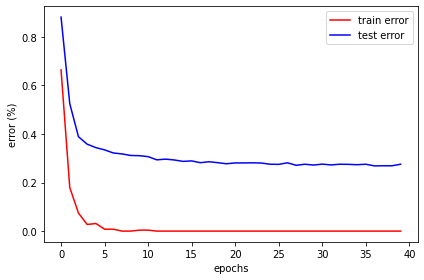

<Figure size 432x288 with 0 Axes>

In [70]:
plot_err(train_errs, test_errs)

Now, we'll train the same model but starting with a large learning rate of 1.0, which will be decayed during training. Instantiate a scheduler in the cell below that decays the learning rate by a factor of 10 every 15 epochs: look at the docs of torch.optim.lr_scheduler to see how to do that.

In [71]:
network2 = CNN(128)
network2.to(device)
optimizer = torch.optim.SGD(network2.parameters(), lr=1.0, weight_decay=1e-2, momentum=0.5, nesterov=True)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,15,gamma=0.1)
train_errs, test_errs = train(40, network2, criterion, optimizer, train_loader, test_loader, scheduler)

Epoch 000/040, Error: 0.84375 || 0.806640625
[1.0]
Epoch 001/040, Error: 0.70703125 || 0.8818359375
[1.0]
Epoch 002/040, Error: 0.73046875 || 0.8818359375
[1.0]
Epoch 003/040, Error: 0.7109375 || 0.90380859375
[1.0]
Epoch 004/040, Error: 0.63671875 || 0.8818359375
[1.0]
Epoch 005/040, Error: 0.5703125 || 0.8818359375
[1.0]
Epoch 006/040, Error: 0.44140625 || 0.8818359375
[1.0]
Epoch 007/040, Error: 0.453125 || 0.78466796875
[1.0]
Epoch 008/040, Error: 0.47265625 || 0.7158203125
[1.0]
Epoch 009/040, Error: 0.34375 || 0.61865234375
[1.0]
Epoch 010/040, Error: 0.4375 || 0.6240234375
[1.0]
Epoch 011/040, Error: 0.3671875 || 0.6240234375
[1.0]
Epoch 012/040, Error: 0.3359375 || 0.70947265625
[1.0]
Epoch 013/040, Error: 0.5 || 0.48046875
[1.0]
Epoch 014/040, Error: 0.3984375 || 0.64697265625
[0.1]
Epoch 015/040, Error: 0.3125 || 0.34326171875
[0.1]
Epoch 016/040, Error: 0.140625 || 0.248046875
[0.1]
Epoch 017/040, Error: 0.08984375 || 0.2275390625
[0.1]
Epoch 018/040, Error: 0.06640625 || 0.

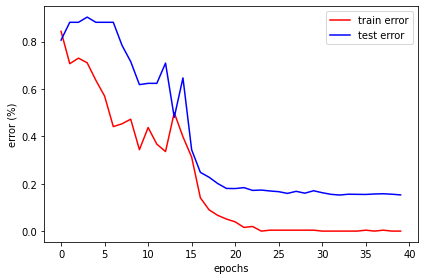

<Figure size 432x288 with 0 Axes>

In [72]:
plot_err(train_errs, test_errs)

**<span style="color:blue">
    How do the two models compare in terms of train and test performance? Discuss your findings and compare them with your observations with SGLD in the first part of this assignment.
</span>**

**<span style="color:red">
    --- ANSWER (BEGIN) ---
</span>**

Model with fixed and small learning rate has training error reaching 0.0 pretty quickly, which also means it reaches the stationary distribution for the testing loss quickly, and the testing loss stays relatively high at 30%. For the model with declining learning rate every 15 epochs, the training error reaches 0.0 much later, as it fluctuates a bit when the learning rate is still large. This also means that it takes longer to reach the stationary distribution of loss, so the model is given the opportunity to explore better parameter values before getting stuck at a local optimum. Therefore, the testing performance reached by the model with declining learning rate at the end is around 15%, which is much better than the model with fixed learning rate. This is similar to the results observed in SGLD, where proper annealing (decaying the learning rate and lowering the temperature) leads to better model performance. 

**<span style="color:red">
    --- ANSWER (END) ---
</span>**

# Estimating a norm-based PAC-Bayes generalization bound

In this last part you'll check whether the two networks trained in the second step have properties that are useful when predicting their generalization capabilities with PAC-Bayes. Recall the general PAC-Bayesian guarantee:

$$L(Q_w) \leq \frac{10}{9} \left( \hat L(Q_w) + \frac{5}{N} \left( \mathcal D(Q_w, P) + \log \frac{1}{\delta} \right)   \right)$$

where $L(Q_w) = \mathbb E_{\epsilon \sim \mathcal N(0, \sigma^2)^d} [L(w + \epsilon)]$ and $\hat L(Q_w) = \mathbb E_{\epsilon \sim \mathcal N(0, \sigma^2)^d} [\hat L(w + \epsilon)]$, with $L, \hat L$ denoting the test and train losses, respectively. Moreover, $Q_w = \mathcal N(w, \sigma^2)^d$ and $\mathcal D(\cdot, \cdot)$ denotes the KL divergence. Let $P = \mathcal N(0, \sigma^2)^d$ (here $d$ denotes the number of parameters of the network).

We will estimate the generalization guarantees given by the above bound as a function of $\sigma$. Note that $L(Q_w)$, $\hat L(Q_w)$ and $\mathcal D(Q_w, P)$ all depend on $\sigma$. You should derive by yourself what $\mathcal D(Q_w, P)$ looks like before moving on.

In the cell below you'll implement the function get_norm, which receives a model as argument and should return the squared $\ell_2$ norm of its parameters, i.e. $\|w\|_2^2 = \sum_i w_i^2$. If you don't know why you'd need this function, go over the lecture slides that cover PAC-Bayes again, or alternatively check this tutorial on PAC-Bayes: https://arxiv.org/pdf/1307.2118.pdf.

In [54]:
def get_norm(network):
    total_squared_norm = 0
    for param in network.parameters():
      squared_norm = torch.pow(torch.linalg.norm(param),2)
      total_squared_norm += squared_norm
    return total_squared_norm

Let's check the squared norm of each of the two networks -- remember that network1 was trained with a small, constant learning rate, while network2 was trained with a large one that was annealed. Both had the same strength for $\ell_2$ regularization.

In [55]:
norm1 = get_norm(network1)
norm2 = get_norm(network2)
print("Squared l2 norm of model 1: {}".format(norm1))
print("Squared l2 norm of model 2: {}".format(norm2))

Squared l2 norm of model 1: 5268.927734375
Squared l2 norm of model 2: 137.98609924316406


Lastly, the function below will estimate $\hat L(Q_w)$ for a given $\sigma$. To do that, you should make 10 copies of the given model, add gaussian noise with variance $\sigma^2$ to its parameters, and compute the average error on the training set.

In [101]:
def pac_test(model, loader, sigma):
    errs = []
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model.eval()
    with torch.no_grad():
        for k in range(10):
            total_correct = 0.
            total_samples = 0.
            # depending on your pytorch version the line above might throw an error
            # if this happens, search online on how to deep copy pytorch models in your version
            model_clone = copy.deepcopy(model)
            model_clone.to(device)

            # insert code here to add gaussian i.i.d. noise to the model's parameters
            for param in model_clone.parameters():
              noise = torch.normal(0,sigma,size=tuple(param.data.size()))
              noise = noise.to(device)
              param.data.add_(noise)
            
            for batch_idx, (data, target) in enumerate(loader):
                data = data.to(device)
                target = target.to(device)
                output = model_clone.forward(data)
                loss = criterion(output, target)
                pred = torch.max(output,1)[1]
                correct = torch.eq(pred,target).sum()
                total_correct += correct.item()
                total_samples += data.shape[0]

            errs.append(1 - total_correct/total_samples)
                
    return sum(errs) / len(errs)

The cells below will compute and print $\hat L(Q_w)$ for 5 different values of $\sigma$ and for each of the two networks trained previously.

In [102]:
for sigma in [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]:
    pac_test_err = pac_test(network1, train_loader, sigma)
    print("Error of model 1 with sigma={}: {} %".format(sigma, 100*pac_test_err))

Error of model 1 with sigma=0.1: 89.921875 %
Error of model 1 with sigma=0.05: 90.0390625 %
Error of model 1 with sigma=0.01: 84.21875 %
Error of model 1 with sigma=0.005: 22.8515625 %
Error of model 1 with sigma=0.001: 0.0 %


In [103]:
for sigma in [1e-1, 5e-2, 1e-2, 5e-3, 1e-3]:
    pac_test_err = pac_test(network2, train_loader, sigma)
    print("Error of model 2 with sigma={}: {} %".format(sigma, 100*pac_test_err))

Error of model 2 with sigma=0.1: 90.3125 %
Error of model 2 with sigma=0.05: 88.6328125 %
Error of model 2 with sigma=0.01: 0.078125 %
Error of model 2 with sigma=0.005: 0.0 %
Error of model 2 with sigma=0.001: 0.0 %


**<span style="color:blue">
    Which network maintains a reasonable performance with the largest $\sigma$? Compare with the parameter norms computed previously. Considering the PAC-Bayes guarantee you derived, which network should have better generalization? In the MNIST experiments, which network actually generalized better?
</span>**

**<span style="color:red">
    --- ANSWER (BEGIN) ---
</span>**

Network2 (decaying learning rate) maintains a reasonable performance (0.078125%) with the larget $\sigma$ (=0.01). This is consistent with the result from norm comparison. We see that the norm for network2 is much smaller. The PAC-Bayes guarantee derived is as follow: 


$$L(Q_w) \leq \frac{10}{9} \left( \hat L(Q_w) + \frac{5}{N} \left( \frac{\| \Phi \|^{2}}{2 \sigma^{2}} + \log \frac{1}{\delta} \right)   \right)$$

We see that the model with lower $\hat L(Q_w)$ and lower $\| \Phi \|^{2}$ will have a lower bound, and hence better theoretical guarantee of good generalization (test error). From our experiment, we see that network2 has lower $\hat L(Q_w)$ for reasonably large $\sigma$, and it has much lower $\| \Phi \|^{2}$, so theoretically, network2 should have better generalization. 

In the MNIST experiements, network2 actually generalized better with around 15% test error after 40 epochs, while network1 stayed at around 27% test error. 


**<span style="color:red">
    --- ANSWER (END) ---
</span>**